<a href="https://colab.research.google.com/github/spdrnl/ecg/blob/master/ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

# Move data from Drive to /tmp

In [2]:
# You can obtain the data from Kaggle at https://www.kaggle.com/shayanfazeli/heartbeat
from google.colab import drive
drive.mount("/tmp/drive")
! unzip "/tmp/drive/My Drive/data/29414_37484_bundle_archive.zip" -d /tmp/ecg
! ls /tmp/ecg

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /tmp/drive
Archive:  /tmp/drive/My Drive/data/29414_37484_bundle_archive.zip
  inflating: /tmp/ecg/mitbih_test.csv  
  inflating: /tmp/ecg/mitbih_train.csv  
  inflating: /tmp/ecg/ptbdb_abnormal.csv  
  inflating: /tmp/ecg/ptbdb_normal.csv  
mitbih_test.csv  mitbih_train.csv  ptbdb_abnormal.csv  ptbdb_normal.csv


# Import and analyse data
## MIT-BIH Arhythmia dataset

In [4]:
mitbih_test = pd.read_csv("/tmp/ecg/mitbih_test.csv", header=None)
mitbih_train = pd.read_csv("/tmp/ecg/mitbih_train.csv", header=None)

In [6]:
len(mitbih_train)

87554

In [7]:
mitbih_labels = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
mitbih_reverse_labels = {v:k for k,v in mitbih_labels.items()}
mitbih_train['labels'] = mitbih_train.iloc[:,-1].replace(mitbih_reverse_labels)
mitbih_test['labels'] = mitbih_test.iloc[:,-1].replace(mitbih_reverse_labels)

In [8]:
print("There are {} nan values in the train data.".format(mitbih_train.isna().sum().sum()))
print("There are {} nan values in the test data.".format(mitbih_test.isna().sum().sum()))

There are 0 nan values in the train data.
There are 0 nan values in the test data.


In [9]:
print("The minimum and maximum values are {}, {}".format(np.min(mitbih_train.iloc[:,:-2].values), np.max(mitbih_train.iloc[:,:-2].values)))

The minimum and maximum values are 0.0, 1.0


Text(0.5, 1.0, 'Distribution of labels in MIT-BIH Arhythmia dataset')

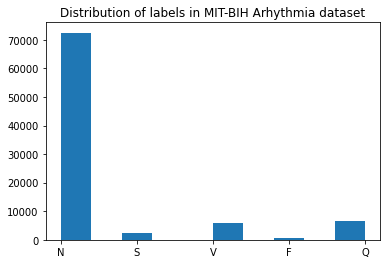

In [10]:
plt.hist(mitbih_train['labels'])
plt.title("Distribution of labels in MIT-BIH Arhythmia dataset")

Text(0.5, 1.0, 'MIT-BIH Arrhythmia Dataset example signal')

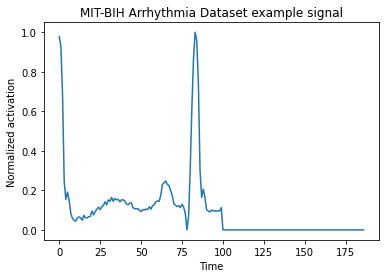

In [11]:
plt.plot(mitbih_train.iloc[0,:-2])
plt.xlabel('Time')
plt.ylabel('Normalized activation')
plt.title("MIT-BIH Arrhythmia Dataset example signal")

## PTB Diagnostic ECG Database

In [12]:
ptbdb_abnormal = pd.read_csv("/tmp/ecg/ptbdb_abnormal.csv", header=None)
ptbdb_normal = pd.read_csv("/tmp/ecg/ptbdb_normal.csv", header=None)

In [13]:
ptbdb_labels = {'Normal': 0, 'Abnormal': 1}
ptbdb_reverse_labels = {v:k for k,v in ptbdb_labels.items()}
ptbdb = pd.concat([ptbdb_abnormal, ptbdb_normal], axis=0, ignore_index=True)
ptbdb['labels'] = ptbdb.iloc[:,-1].replace(ptbdb_reverse_labels)

In [14]:
print("There are {} nan values in the train data.".format(mitbih_train.isna().sum().sum()))
print("There are {} nan values in the test data.".format(mitbih_test.isna().sum().sum()))

There are 0 nan values in the train data.
There are 0 nan values in the test data.


In [15]:
print("The minimum and maximum values are {}, {}".format(np.min(ptbdb.iloc[:,:-2].values), np.max(ptbdb.iloc[:,:-2].values)))

The minimum and maximum values are 0.0, 1.0


Text(0.5, 1.0, 'Distribution of the PTB Diagnostic ECG Database labels')

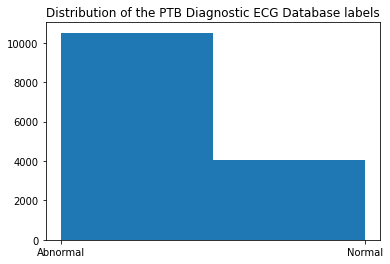

In [16]:
plt.hist(ptbdb['labels'], bins=2)
plt.title("Distribution of the PTB Diagnostic ECG Database labels")

In [17]:
len(ptbdb)

14552

Text(0.5, 1.0, 'PTB Diagnostic ECG Database example signal')

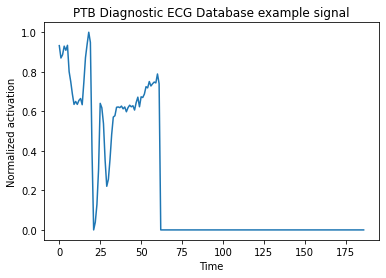

In [ ]:
plt.plot(ptbdb.iloc[0,:-2])
plt.xlabel('Time')
plt.ylabel('Normalized activation')
plt.title("PTB Diagnostic ECG Database example signal")

## Creating datasets

In [19]:
print(ptbdb.shape)
print(mitbih_train.shape)
print(mitbih_test.shape)

(14552, 189)
(87554, 189)
(21892, 189)


In [20]:
X_mitbih_train, X_mitbih_val, y_mitbih_train, y_mitbih_val = train_test_split(mitbih_train.iloc[:,:-2].values, mitbih_train.iloc[:,-2].values, test_size=0.2, random_state=42)
X_mitbih_test = mitbih_test.iloc[:,:-2].values
y_mitbih_test = mitbih_test.iloc[:,-2].values

X_ptbdb_train, X_ptbdb_test, y_ptbdb_train, y_ptbdb_test = train_test_split(ptbdb.iloc[:,:-2].values, ptbdb.iloc[:,-2].values, test_size=0.2, random_state=42)
X_ptbdb_train, X_ptbdb_val, y_ptbdb_train, y_ptbdb_val = train_test_split(X_ptbdb_train, y_ptbdb_train, test_size=0.2, random_state=42)

# Baseline MLP

In [25]:
# Copied from https://github.com/avanwyk/tensorflow-projects/blob/master/lr-finder/lr_finder.py
# Apache License 2.0

from tensorflow.keras.callbacks import Callback

class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

## Baseline PTB check

In [24]:
def get_base_model(categories=2):
  return keras.Sequential([
    keras.layers.Dense(15, activation='relu', input_shape=[187], kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.Dense(5, activation='relu'),
    (keras.layers.Dense(1, activation='sigmoid') if categories == 2 else keras.layers.Dense(5, activation='softmax'))                   
  ])

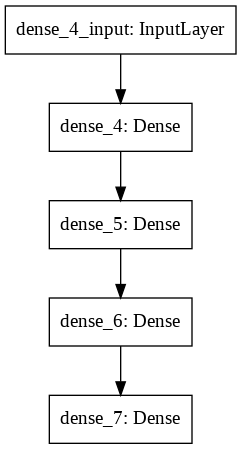

In [26]:
tf.keras.utils.plot_model(
    get_base_model(),
    to_file="model.png")

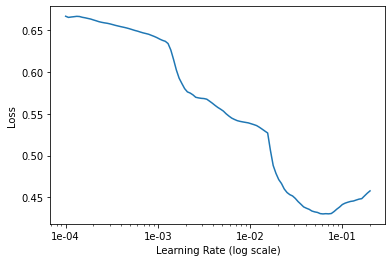

In [32]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = get_base_model() 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-4, end_lr= 1e-1, max_steps=100, smoothing=0.6)
_ = model.fit(X_ptbdb_train, y_ptbdb_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [33]:
N = X_ptbdb_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

from tensorflow_addons.optimizers import CyclicalLearningRate
lr_schedule = CyclicalLearningRate(1e-3, 1e-2, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model = get_base_model() 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_ptbdb_train, y_ptbdb_train, validation_data=(X_ptbdb_val, y_ptbdb_val), shuffle=True, batch_size=batch_size, epochs=300)

Epoch 1/300
73/73 [==============================] - 0s 4ms/step - loss: 0.5773 - accuracy: 0.7007 - val_loss: 0.4713 - val_accuracy: 0.7870
Epoch 2/300
73/73 [==============================] - 0s 3ms/step - loss: 0.4314 - accuracy: 0.7866 - val_loss: 0.3874 - val_accuracy: 0.8205
Epoch 3/300
73/73 [==============================] - 0s 3ms/step - loss: 0.3804 - accuracy: 0.8217 - val_loss: 0.3522 - val_accuracy: 0.8373
Epoch 4/300
73/73 [==============================] - 0s 3ms/step - loss: 0.3502 - accuracy: 0.8343 - val_loss: 0.3389 - val_accuracy: 0.8532
Epoch 5/300
73/73 [==============================] - 0s 3ms/step - loss: 0.3371 - accuracy: 0.8485 - val_loss: 0.3290 - val_accuracy: 0.8536
Epoch 6/300
73/73 [==============================] - 0s 3ms/step - loss: 0.3286 - accuracy: 0.8504 - val_loss: 0.3300 - val_accuracy: 0.8454
Epoch 7/300
73/73 [==============================] - 0s 3ms/step - loss: 0.3119 - accuracy: 0.8582 - val_loss: 0.3269 - val_accuracy: 0.8510
Epoch 8/300
7

In [34]:
def pretty_plot(history, field, fn):
  def plot(data, val_data, title):
    plt.plot(range(1, len(data)+1), data, label='train')
    plt.plot(range(1, len(data)+1), val_data, label='validation')
    plt.xlabel('Epoch')
    plt.ylabel(field)
    plt.xticks(range(1, len(data)+1, 25))
    plt.title(title)
    plt.legend()
    plt.show()

  data = history.history[field]
  val_data = history.history['val_' + field]
  tail = int(0.15 * len(data))

  plot(data, val_data, "{} over epochs (best {:06.4f})".format(field, fn(val_data)))
  plot(data[-tail:], val_data[-tail:], "{} over last {} epochs".format(field, tail))

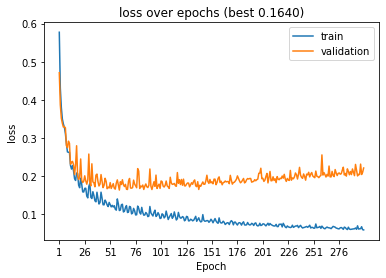

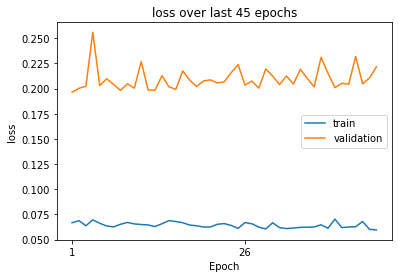

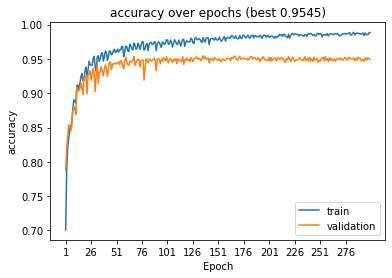

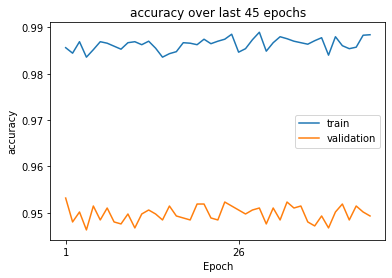

In [35]:
pretty_plot(history, 'loss', lambda x: min(x))
pretty_plot(history, 'accuracy', lambda x: max(x))

In [36]:
model.evaluate(X_ptbdb_test, y_ptbdb_test)

91/91 [==============================] - 0s 2ms/step - loss: 0.2341 - accuracy: 0.9450


[0.23411230742931366, 0.9450360536575317]

# ResNet model

In [ ]:
def get_resnet_model(categories=2):
  def residual_block(X, kernels, stride):
    out = keras.layers.Conv1D(kernels, stride, padding='same')(X)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.add([X, out])
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(5, 2)(out)
    return out

  kernels = 32
  stride = 5

  inputs = keras.layers.Input([187,1])
  X = keras.layers.Conv1D(kernels, stride)(inputs)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = keras.layers.Flatten()(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  output = (keras.layers.Dense(1, activation='sigmoid')(X) if categories == 2 else keras.layers.Dense(5, activation='softmax')(X))

  model = keras.Model(inputs=inputs, outputs=output)
  return model

## ResNet PTB replication

In [ ]:
X_ptbdbl_train = np.expand_dims(X_ptbdb_train, -1)
y_ptbdbl_train = np.expand_dims(y_ptbdb_train, -1)
X_ptbdbl_val = np.expand_dims(X_ptbdb_val, -1)
y_ptbdbl_val = np.expand_dims(y_ptbdb_val, -1)

optimizer = keras.optimizers.Adam(lr=0.001)
model = get_resnet_model()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_ptbdbl_train, y_ptbdbl_train, validation_data=(X_ptbdbl_val, y_ptbdbl_val), shuffle=True, batch_size=128, epochs=50)

Epoch 1/50
73/73 [==============================] - 1s 20ms/step - loss: 0.4824 - accuracy: 0.7676 - val_loss: 0.3288 - val_accuracy: 0.8647
Epoch 2/50
73/73 [==============================] - 1s 14ms/step - loss: 0.2720 - accuracy: 0.8899 - val_loss: 0.1880 - val_accuracy: 0.9236
Epoch 3/50
73/73 [==============================] - 1s 14ms/step - loss: 0.1709 - accuracy: 0.9377 - val_loss: 0.1266 - val_accuracy: 0.9511
Epoch 4/50
73/73 [==============================] - 1s 14ms/step - loss: 0.1171 - accuracy: 0.9552 - val_loss: 0.0976 - val_accuracy: 0.9614
Epoch 5/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0877 - accuracy: 0.9672 - val_loss: 0.0819 - val_accuracy: 0.9738
Epoch 6/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0700 - accuracy: 0.9767 - val_loss: 0.0791 - val_accuracy: 0.9708
Epoch 7/50
73/73 [==============================] - 1s 14ms/step - loss: 0.0575 - accuracy: 0.9792 - val_loss: 0.0523 - val_accuracy: 0.9807
Epoch 8/50
73

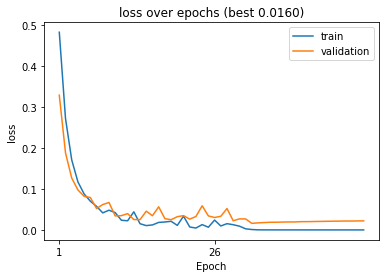

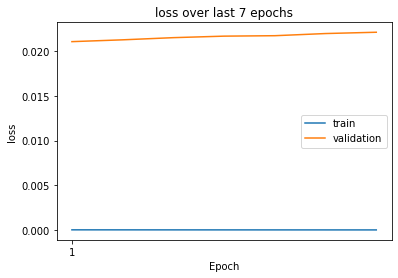

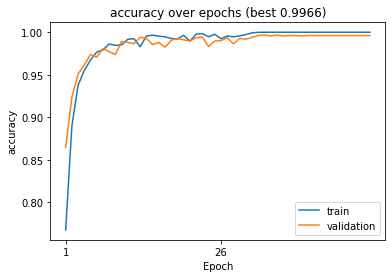

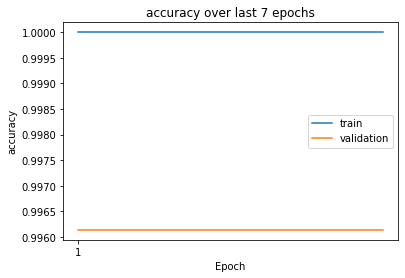

In [ ]:
pretty_plot(history, 'loss', lambda x: min(x))
pretty_plot(history, 'accuracy', lambda x: max(x))

## ResNet MIH replication

In [ ]:
# The 1D convolutions expect an extra dimension in the input data 
X_mitbih_train = np.expand_dims(X_mitbih_train, -1)
y_mitbih_train = np.expand_dims(y_mitbih_train, -1)
X_mitbih_val = np.expand_dims(X_mitbih_val, -1)
y_mitbih_val = np.expand_dims(y_mitbih_val, -1)
X_mitbih_test = np.expand_dims(X_mitbih_test, -1)
y_mitbih_test = np.expand_dims(y_mitbih_test, -1)

optimizer = keras.optimizers.Adam(lr=0.001)
model = get_resnet_model(5)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_mitbih_train, y_mitbih_train, validation_data=(X_mitbih_val, y_mitbih_val), shuffle=True, batch_size=128, epochs=50)

Epoch 1/50
548/548 [==============================] - 8s 15ms/step - loss: 0.2886 - accuracy: 0.9173 - val_loss: 0.1506 - val_accuracy: 0.9611
Epoch 2/50
548/548 [==============================] - 7s 13ms/step - loss: 0.1200 - accuracy: 0.9671 - val_loss: 0.1106 - val_accuracy: 0.9692
Epoch 3/50
548/548 [==============================] - 7s 14ms/step - loss: 0.0922 - accuracy: 0.9745 - val_loss: 0.0815 - val_accuracy: 0.9772
Epoch 4/50
548/548 [==============================] - 7s 13ms/step - loss: 0.0779 - accuracy: 0.9781 - val_loss: 0.0863 - val_accuracy: 0.9777
Epoch 5/50
548/548 [==============================] - 7s 13ms/step - loss: 0.0700 - accuracy: 0.9802 - val_loss: 0.0760 - val_accuracy: 0.9799
Epoch 6/50
548/548 [==============================] - 7s 13ms/step - loss: 0.0639 - accuracy: 0.9819 - val_loss: 0.0728 - val_accuracy: 0.9789
Epoch 7/50
548/548 [==============================] - 7s 13ms/step - loss: 0.0568 - accuracy: 0.9837 - val_loss: 0.0689 - val_accuracy: 0.9804

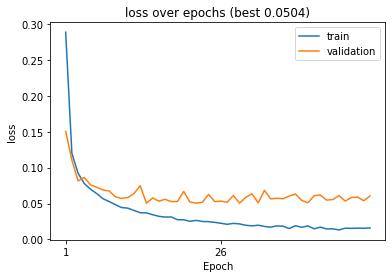

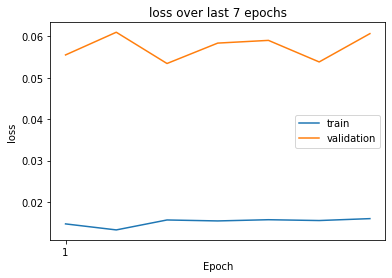

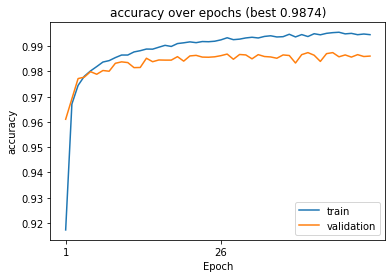

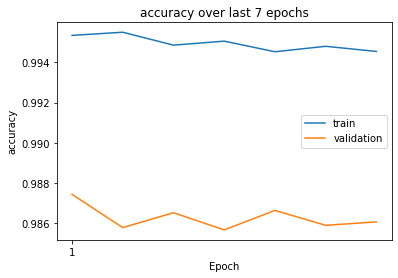

In [ ]:
pretty_plot(history, 'loss', lambda x: min(x))
pretty_plot(history, 'accuracy', lambda x: max(x))

In [ ]:
X_mitbih_test = model.evaluate(X_mitbih_test, y_mitbih_test)

685/685 [==============================] - 3s 4ms/step - loss: 0.0690 - accuracy: 0.9853


# Transfer learning application

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_66 (Conv1D)              (None, 183, 32)      192         input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_67 (Conv1D)              (None, 183, 32)      5152        conv1d_66[0][0]                  
__________________________________________________________________________________________________
re_lu_60 (ReLU)                 (None, 183, 32)      0           conv1d_67[0][0]                  
____________________________________________________________________________________________

In [ ]:
# Reuse the MIT trained model, except the last three layers
def get_transfer_model(model):
  model.trainable = False
  model_input = model.inputs
  model_output = model.get_layer('flatten_6').output

  X = keras.layers.Dense(32, activation='relu')(model_output)
  X = keras.layers.Dense(32, activation='relu')(X)
  out = keras.layers.Dense(1, activation='sigmoid')(X)

  transfer_model = keras.Model(inputs=model_input, outputs=out)
  return transfer_model

get_transfer_model(model).summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_66 (Conv1D)              (None, 183, 32)      192         input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_67 (Conv1D)              (None, 183, 32)      5152        conv1d_66[0][0]                  
__________________________________________________________________________________________________
re_lu_60 (ReLU)                 (None, 183, 32)      0           conv1d_67[0][0]                  
____________________________________________________________________________________________

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.001)
transfer_model = get_transfer_model(model)
transfer_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = transfer_model.fit(X_ptbdbl_train, y_ptbdbl_train, validation_data=(X_ptbdbl_val, y_ptbdbl_val), shuffle=True, batch_size=128, epochs=50)

Epoch 1/50
73/73 [==============================] - 1s 13ms/step - loss: 0.7828 - accuracy: 0.6988 - val_loss: 0.4469 - val_accuracy: 0.8046
Epoch 2/50
73/73 [==============================] - 1s 9ms/step - loss: 0.4189 - accuracy: 0.8091 - val_loss: 0.3767 - val_accuracy: 0.8317
Epoch 3/50
73/73 [==============================] - 1s 10ms/step - loss: 0.3626 - accuracy: 0.8332 - val_loss: 0.3358 - val_accuracy: 0.8574
Epoch 4/50
73/73 [==============================] - 1s 9ms/step - loss: 0.3254 - accuracy: 0.8549 - val_loss: 0.3141 - val_accuracy: 0.8647
Epoch 5/50
73/73 [==============================] - 1s 10ms/step - loss: 0.2971 - accuracy: 0.8695 - val_loss: 0.2927 - val_accuracy: 0.8746
Epoch 6/50
73/73 [==============================] - 1s 9ms/step - loss: 0.2745 - accuracy: 0.8835 - val_loss: 0.2709 - val_accuracy: 0.8828
Epoch 7/50
73/73 [==============================] - 1s 9ms/step - loss: 0.2578 - accuracy: 0.8911 - val_loss: 0.2647 - val_accuracy: 0.8888
Epoch 8/50
73/73 

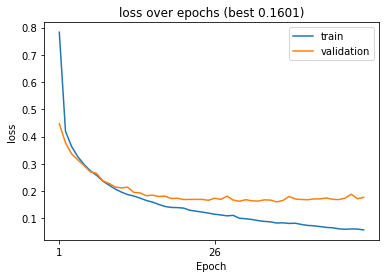

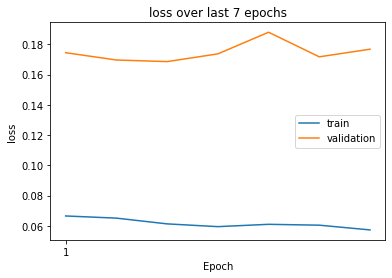

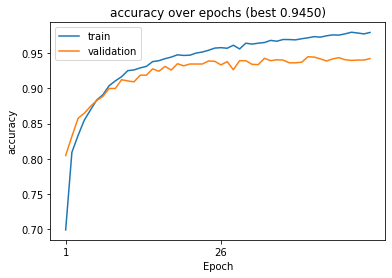

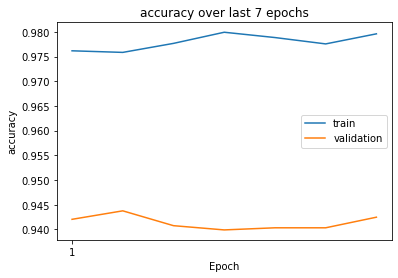

In [ ]:
pretty_plot(history, 'loss', lambda x: min(x))
pretty_plot(history, 'accuracy', lambda x: max(x))